<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* OUKSILI, Samy
* Nom, prénom
* Nom, prénom

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [2]:
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
    tree,
    neighbors
)

In [3]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
Je cherche a savoir les causes de déces d'un patient en compte tenu de son dossier médical , pour ca je vai faire une analyse statique prédictive pour prédire la survie ou le deces des patients pendant leur séjour à l'hopital . Leur dossier médical consiste donc aux 342 variables de l'état de chaque patient je vai donc analyser avec 80 000 patients.
</span>

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
balanced_accuracy_score c'est la précision équilibrée dans les problèmes de classification binaire et multiclasse pour traiter les jeux de données déséquilibres cette fonction renvoie alors la précision moyenne par classe et accuracy_score renvoie simplement le pourcentage d'étiquettes que j'ai prédit correctement
</span>

## 2. Chargement des données

In [4]:
DATA = Path(
    "public_data"
).expanduser()

# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [5]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [7]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [8]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [9]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

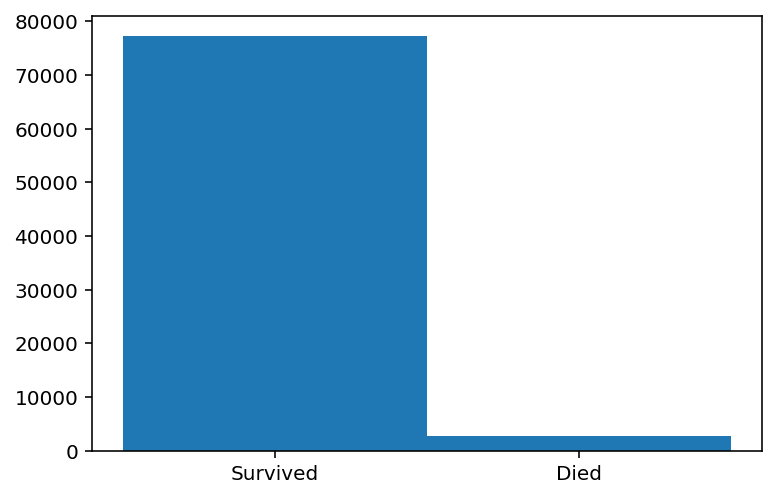

In [10]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

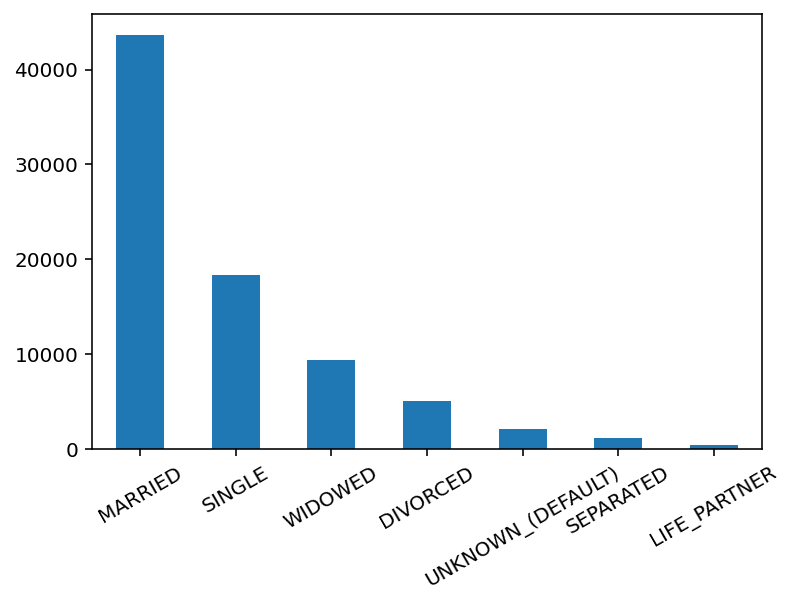

In [17]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

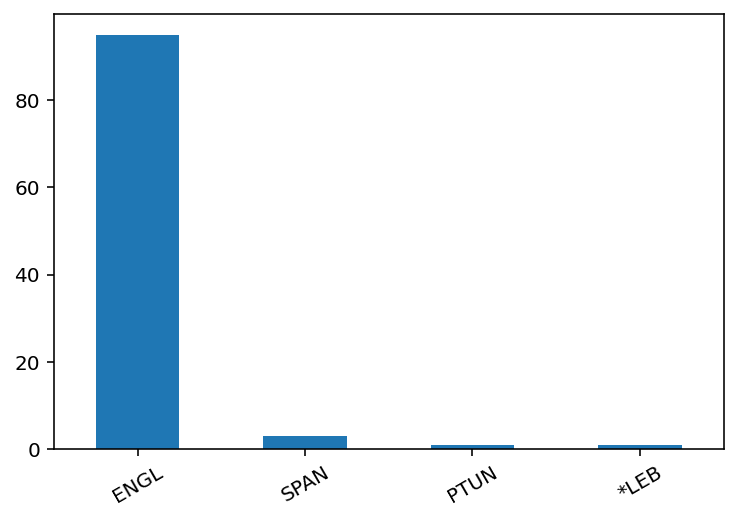

In [20]:
# TODO: Bar plot of another variable
x_marital_cnts = x_df["LANGUAGE"][:100].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

#### Corrélations

In [21]:
corr_df = x_df.corr()
with pd.option_context("display.float_format", "{:.4g}".format):
    display(corr_df)


,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
AGE,1,-0.1606,-0.1402,-0.1545,-0.1367,0.02515,-0.02947,-0.1923,-0.07934,-0.2136,...,NaN,-0.003626,NaN,NaN,NaN,0.01244,0.08454,0.01731,0.1588,0.04508
HR_MIN_DAY1,-0.1606,1,0.7033,0.8557,0.01285,-0.1054,-0.09542,0.1854,0.08115,0.2164,...,NaN,-0.004816,NaN,NaN,NaN,-0.03328,-0.0301,0.03157,-0.05731,-0.0655
HR_MAX_DAY1,-0.1402,0.7033,1,0.8181,-0.09451,0.06398,-0.04704,0.07282,0.2573,0.2303,...,NaN,-0.004101,NaN,NaN,NaN,-0.07801,-0.002734,0.02417,-0.09091,-0.0704
HR_MEAN_DAY1,-0.1545,0.8557,0.8181,1,-0.05672,-0.04919,-0.1016,0.1248,0.171,0.2183,...,NaN,-0.004903,NaN,NaN,NaN,-0.05576,-0.02927,0.03284,-0.09903,-0.04195
SYS_BP_MIN_DAY1,-0.1367,0.01285,-0.09451,-0.05672,1,0.3612,0.7083,0.5382,0.2273,0.4741,...,NaN,-0.0007081,NaN,NaN,NaN,0.07281,-0.1131,-0.01814,-0.02579,0.08254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Othnervdx,0.01244,-0.03328,-0.07801,-0.05576,0.07281,0.104,0.1119,0.00659,0.09638,0.05499,...,NaN,-0.001459,NaN,NaN,NaN,1,-0.06713,-0.004357,0.05347,0.01815
Hrtvalvedx,0.08454,-0.0301,-0.002734,-0.02927,-0.1131,-0.09473,-0.1379,-0.07826,-0.1205,-0.128,...,NaN,-0.001392,NaN,NaN,NaN,-0.06713,1,0.04895,0.01267,0.01431
Carditis,0.01731,0.03157,0.02417,0.03284,-0.01814,-0.03337,-0.03168,-0.01237,-0.009074,-0.003896,...,NaN,-0.0003298,NaN,NaN,NaN,-0.004357,0.04895,1,-0.007003,0.03333
HTN,0.1588,-0.05731,-0.09091,-0.09903,-0.02579,0.06193,0.05252,-0.03685,-0.03838,-0.05138,...,NaN,-0.003248,NaN,NaN,NaN,0.05347,0.01267,-0.007003,1,-0.1459


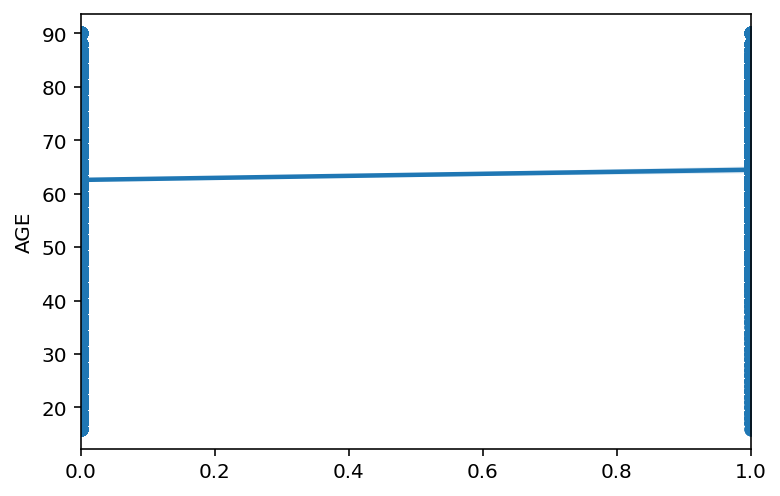

In [22]:
sns.regplot(data=x_df,x=ys,y="AGE");

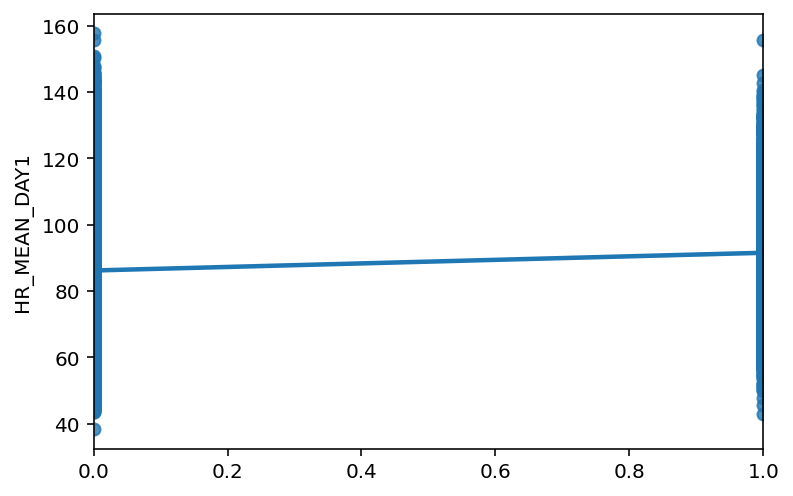

In [23]:
sns.regplot(data=x_df,x=ys,y="HR_MEAN_DAY1");

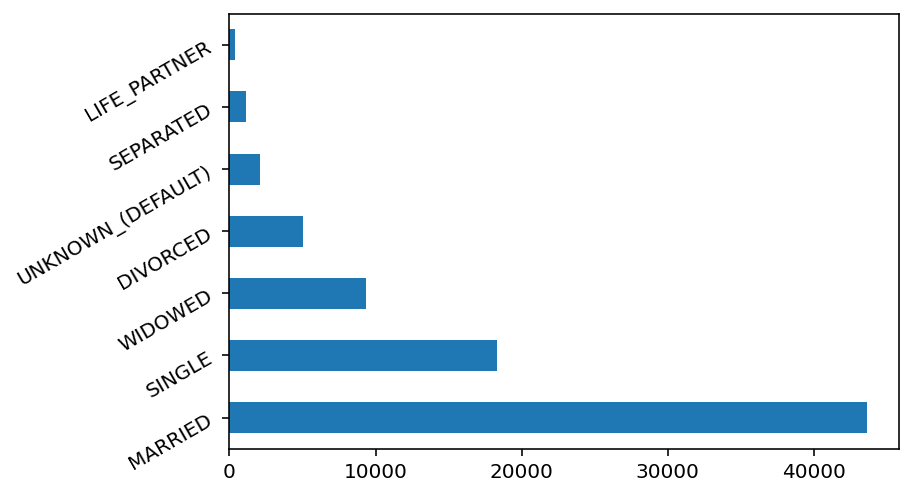

In [24]:
# TODO: Bar plot of the variables most correlated with y
x_MARITAL_cnts= x_df["MARITAL_STATUS"].value_counts()
x_MARITAL_cnts.plot.barh(rot=30)
plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

#### Autres graphiques ou résultats d'une analyse exploratoire

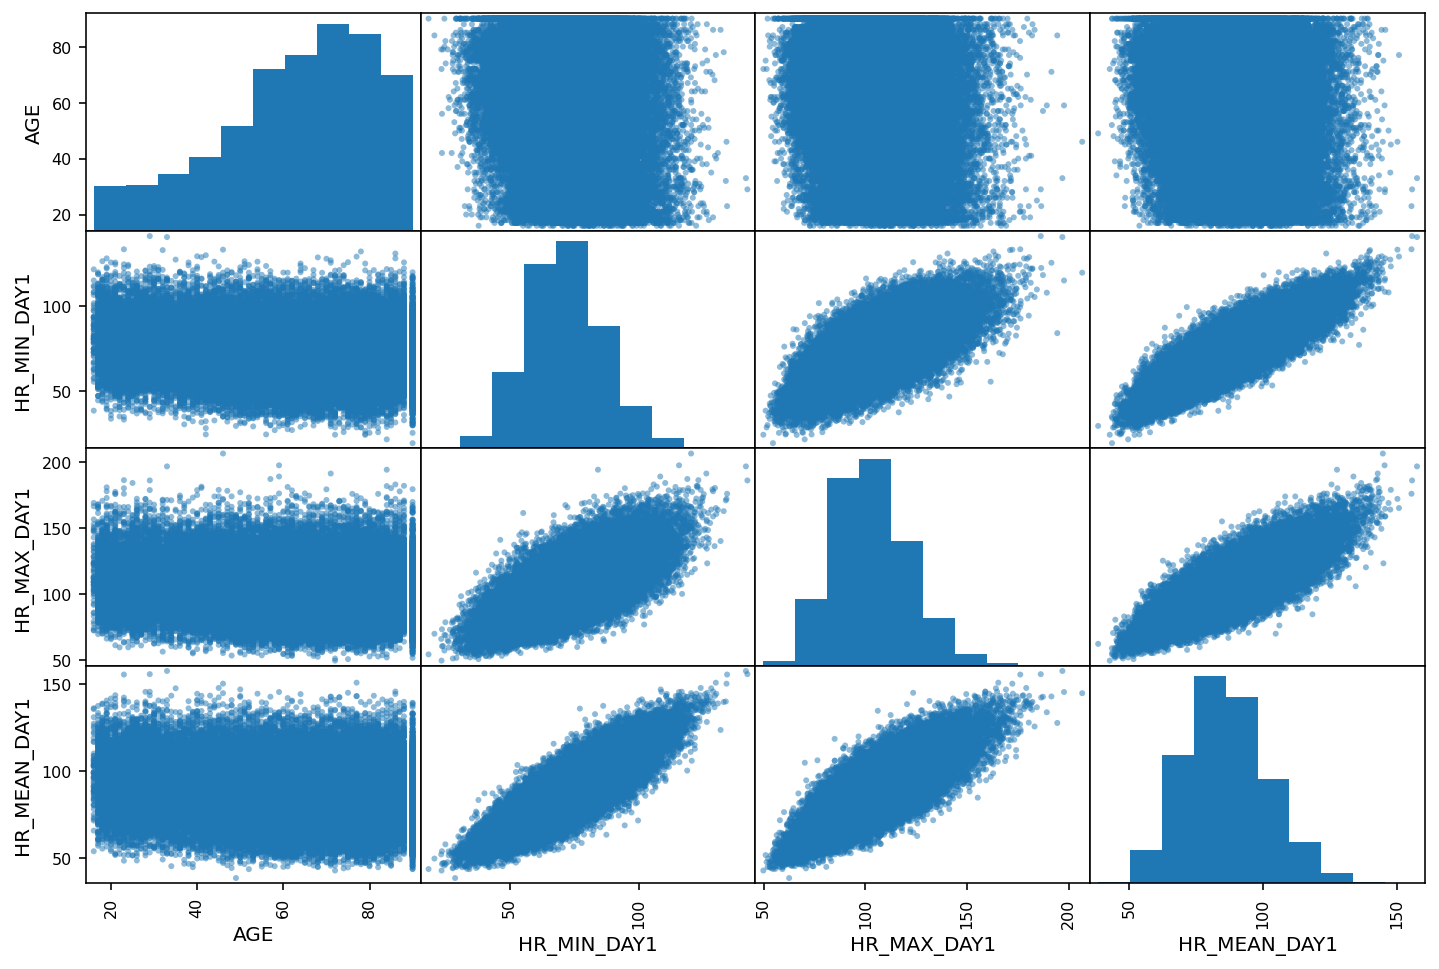

In [16]:
FTS = ["AGE", "HR_MIN_DAY1", "HR_MAX_DAY1", "HR_MEAN_DAY1"]
pd.plotting.scatter_matrix(x_df[FTS], figsize=(12, 8))
plt.show()


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [17]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [18]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [19]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [20]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [21]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [22]:
print(x_df.isna().any().any(), x_test_df.isna().any().any())

False False


In [23]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Domain Expertise

Simplifiez les données en regroupant par exemple les catégories rares.

In [24]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
PROTESTANT_QUAKER    2208
UNOBTAINABLE         2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [25]:
# TODO: Other application of merge_rare_categories
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"
merge_rare_categories([x_df, x_test_df], col="ETHNICITY", keep_n=5)
print(x_test_df["ETHNICITY"].value_counts())

Index(['WHITE', 'UNKNOWN/NOT_SPECIFIED', 'BLACK/AFRICAN_AMERICAN', 'OTHER',
       'HISPANIC_OR_LATINO'],
      dtype='object')
WHITE                     14930
OTHER                      2676
UNKNOWN/NOT_SPECIFIED      1088
BLACK/AFRICAN_AMERICAN      930
HISPANIC_OR_LATINO          377
Name: ETHNICITY, dtype: int64


In [26]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"
merge_rare_categories([x_df, x_test_df], col="INSURANCE", keep_n=5)
print(x_test_df["INSURANCE"].value_counts())

Index(['Medicare', 'Private', 'Medicaid', 'Government', 'Self_Pay'], dtype='object')
Medicare      11250
Private        5896
Medicaid       1585
Government      721
Self_Pay        549
Name: INSURANCE, dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [27]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [28]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [30]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [31]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,3,0,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [33]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [34]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df.iloc[:len(x_df)].copy()
x_test_1hot_df = x_all_1hot_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 337) (20001, 337)
(79999, 427) (20001, 427)


#### Suppression des variables à valeur unique (constantes)

In [35]:
const_cols = {col for col in x_1hot_df if len(x_1hot_df[col].unique()) == 1}
len(const_cols)

173

In [36]:
x_1hot_df.drop(const_cols, axis="columns", inplace=True)
x_test_1hot_df.drop(const_cols, axis="columns", inplace=True)

print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 254) (20001, 254)


### Création de l'ensemble de validation

In [37]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [38]:
# TODO: PCA
nombre_comp = 10

pca = decomposition.PCA(n_components=nombre_comp)
data_pcs = pca.fit_transform(preprocessing.StandardScaler().fit_transform(x_1hot_df))

data_pcs.shape

(79999, 10)

In [39]:
# 2. Instantiaiton
model_pca = linear_model.LogisticRegression(max_iter=(10000))

# 3. Apprentissage (fit) du model
model_pca.fit(x_train, y_train)

# 4. Prédire sur les données de test
y_pred = model_pca.predict(x_valid)

In [40]:
score = metrics.accuracy_score(y_valid, y_pred)
print("le score est :" , f"{score :.04f}")

le score est : 0.9643


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

In [41]:
def tracer_des_points(xs, ys, ft_names=None, target_names=None, colors=None):
    if target_names is None:
        target_names = {}
    if colors is None:
        colors = {}

    for y_val in set(ys):
        plt.scatter(
            xs[ys == y_val, 0],
            xs[ys == y_val, 1],
            color=colors.get(y_val),
            alpha=0.8,
            label=target_names.get(y_val),
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("2 Dimension PCA")
   

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

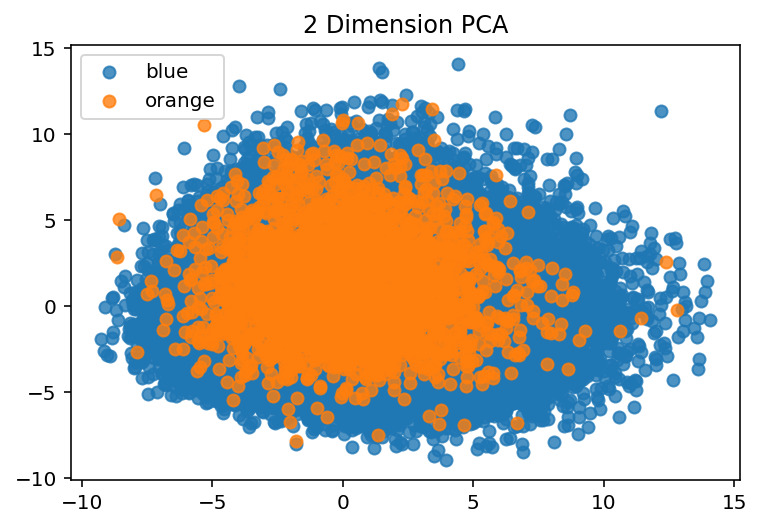

In [43]:
COLORS = {0: "blue", 1:"orange"}
tracer_des_points(data_pcs, ys, ["PC-1","PC-2"], COLORS)

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [44]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [46]:
# model = linear_model.LogisticRegression(max_iter=10000)
model = neighbors.KNeighborsClassifier(n_neighbors=5)
#model = tree.DecisionTreeClassifier()

# TODO: Try other models

model.fit(x_train, y_train)  # training

KNeighborsClassifier()

## 6. Évaluations

In [47]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")
y_valid.value_counts()

Balanced accuracy score: 0.502


0    23129
1      871
dtype: int64

In [52]:
model1 = ensemble.RandomForestClassifier(n_estimators=10)
model1.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

In [53]:
y_pred = model1.predict(x_valid)  # predictions

score1 = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score1:.3g}")
y_valid.value_counts()

Balanced accuracy score: 0.5


0    23129
1      871
dtype: int64

### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [54]:
CV = 10
SCORING = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [57]:
# TODO: Cross-Validation
scores = model_selection.cross_val_score(
    model, data_pcs, ys, cv=10, scoring=SCORINGS
)
print(scores)

print(f"\n{SCORINGS}: {scores.mean():.2f}, avec std dev: {scores.std():.2f}\n")

[0.505 0.506 0.499 0.503 0.501 0.499 0.501 0.501 0.499 0.506]

balanced_accuracy: 0.50, avec std dev: 0.00



In [60]:
scores2 = model_selection.cross_val_score(
    model1, data_pcs, ys, cv=10, scoring=SCORINGS
)
print(scores2)

print(f"\n{SCORINGS}: {scores2.mean():.2f}, avec std dev: {scores2.std():.2f}\n")

[0.5   0.5   0.5   0.5   0.5   0.502 0.5   0.5   0.5   0.5  ]

balanced_accuracy: 0.50, avec std dev: 0.00



* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

<span style="color:red">
    Répondre ci-dessous
</span>

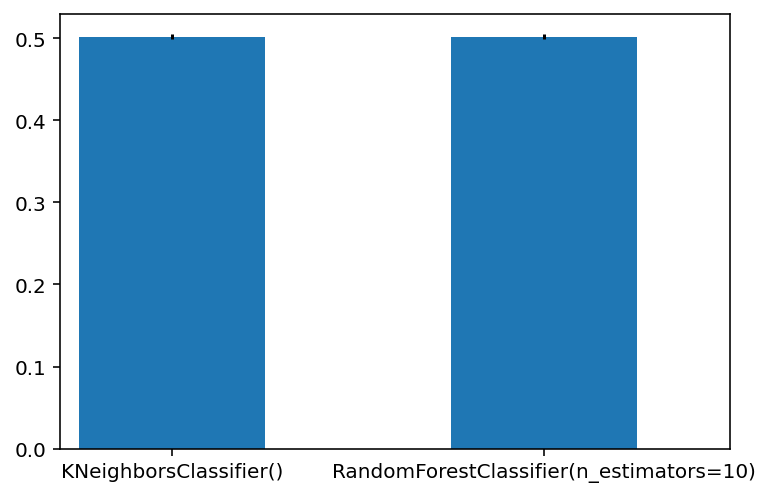

In [71]:
# TODO: Boxplot ou Barplot
plt.bar([str(model),(str(model1))], scores.mean(),scores2.mean(), yerr=scores.std())
plt.xlim(-0.3, 1.5)
plt.show()

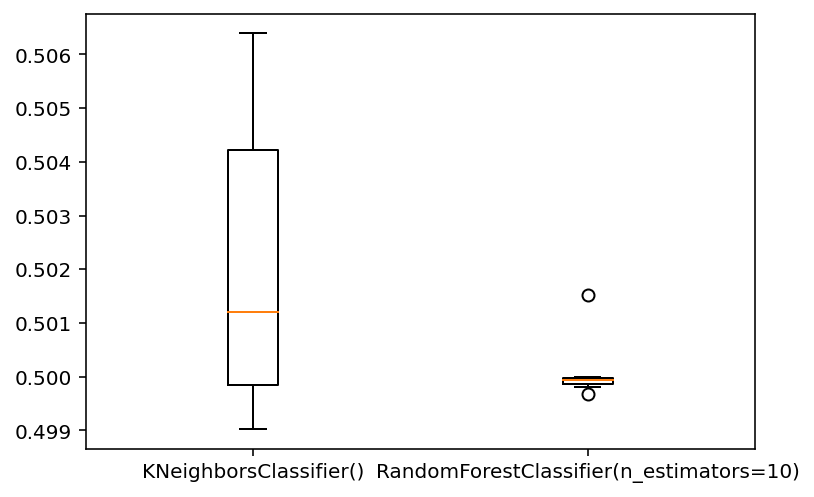

In [73]:
plt.boxplot([(scores),(scores2)])
plt.xticks([1 , 2 ], [str(model),str(model1)])
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [74]:
# TODO: Confusion Mtx
metrics.roc_auc_score(y_valid,model.predict_proba(x_valid)[:, 1])

0.5530142451172004

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

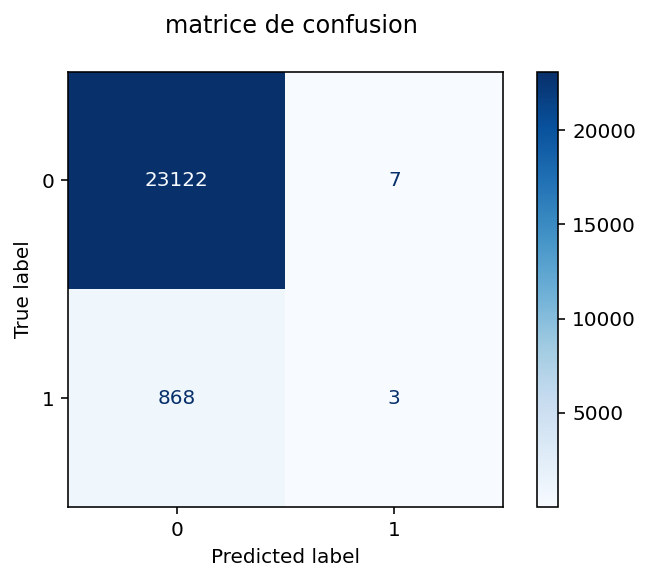

In [77]:
# TODO: ROC
disp = metrics.plot_confusion_matrix(model, x_valid, y_valid, cmap=plt.cm.Blues)
disp.figure_.suptitle("matrice de confusion")
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [78]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [79]:
predictions = model.predict(x_test_1hot_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions\submission_2021-05-24T23-15-31.zip


---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---